## 1- *Import Needed Modules*
--- 

In [25]:
import re, string
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm
from tensorflow.keras import layers

In [26]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

## 2 - *Function to get different datasets*
---

In [27]:

def get_text_ds(name: str):
    if name == "imdb_reviews":
        ds = tfds.load("imdb_reviews", split="unsupervised", as_supervised=False)
        return ds.map(lambda x: x["text"])
    if name == "ag_news_subset":
        ds = tfds.load("ag_news_subset", split="train", as_supervised=False)
        return ds.map(lambda x: tf.strings.join([x["title"], x["description"]], separator=" "))
    if name == "wikipedia":
        ds = tfds.load("wikipedia/20230601.en", split="train", as_supervised=False)
        return ds.map(lambda x: x["text"])
    if name == "wiki40b":
        ds = tfds.load("wiki40b/en", split="train", as_supervised=False)
        return ds.map(lambda x: x["text"])
    if name == "pg19":
        ds = tfds.load("pg19", split="train", as_supervised=False)
        return ds.map(lambda x: x["text"])
    raise ValueError("Unknown dataset name")

In [28]:
DATASET = "ag_news_subset"   
text_ds = get_text_ds(DATASET).filter(lambda x: tf.cast(tf.strings.length(x), tf.bool))


In [29]:
text_ds = text_ds.take(200_000)

In [30]:
def custom_standardization(x):
    x = tf.strings.lower(x)
    return tf.strings.regex_replace(x, "[%s]" % re.escape(string.punctuation), "")


- Lowercase , and remove punctuation.

In [31]:
vocab_size = 20_000
sequence_length = 20

## 3 - *Vectorization*
---

In [32]:
vectorize = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

- builds word → integer ID

- truncates / pads sentences to fixed length

- `max_tokens = vocab_size`

- ids depend on frequency

In [33]:
vectorize.adapt(text_ds.batch(1024))
inverse_vocab = vectorize.get_vocabulary()

- scans corpus 

- builds vocab + Frequency stats

In [34]:
print(f"Random words : {[inverse_vocab[i] for i in range(10, 20)]}")

Random words : [np.str_('39s'), np.str_('that'), np.str_('with'), np.str_('as'), np.str_('at'), np.str_('its'), np.str_('is'), np.str_('new'), np.str_('by'), np.str_('said')]


## 4 - *Integer sequences*
---

In [35]:
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize).unbatch()
sequences = list(text_vector_ds.as_numpy_iterator())

In [36]:
len(sequences)

120000

In [39]:
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
    targets, contexts, labels = [], [], []
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

    for seq in tqdm.tqdm(sequences):
        positive_pairs, _ = tf.keras.preprocessing.sequence.skipgrams(
            seq,
            vocabulary_size=vocab_size,
            sampling_table=sampling_table,
            window_size=window_size,
            negative_samples=0,
            seed=int(seed),   # FIX: ensure an integer seed (Py3.12)
        )

        for target_word, context_word in positive_pairs:
            context_class = tf.expand_dims(tf.constant([context_word], dtype=tf.int64), 1)

            negative, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=int(seed),  # also keep this int
                name="negative_sampling",
            )

            context = tf.concat([tf.squeeze(context_class, 1), negative], axis=0)
            label = tf.constant([1] + [0] * num_ns, dtype=tf.int64)

            targets.append(target_word)
            contexts.append(context)
            labels.append(label)

    return np.array(targets), np.array(contexts), np.array(labels)


In [40]:
window_size = 2
num_ns = 4
targets, contexts, labels = generate_training_data(
    sequences, window_size=window_size, num_ns=num_ns, vocab_size=vocab_size, seed=SEED
)

100%|██████████| 120000/120000 [16:40<00:00, 119.97it/s]


In [41]:
BATCH_SIZE = 1024
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(10_000).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(AUTOTUNE)


In [42]:

class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.target_embedding = layers.Embedding(vocab_size, embedding_dim, name="w2v_embedding")
        self.context_embedding = layers.Embedding(vocab_size, embedding_dim)

    def call(self, pair):
        target, context = pair
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        word_emb = self.target_embedding(target)        # (batch, embed)
        context_emb = self.context_embedding(context)   # (batch, num_ctx, embed)
        return tf.einsum("be,bce->bc", word_emb, context_emb)  # logits


In [43]:
embedding_dim = 128
model = Word2Vec(vocab_size, embedding_dim)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.fit(dataset, epochs=5)

Epoch 1/5
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 151s 67ms/step - accuracy: 0.3371 - loss: 1.5061
Epoch 2/5
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 140s 63ms/step - accuracy: 0.5542 - loss: 1.1521
Epoch 3/5
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 145s 65ms/step - accuracy: 0.6377 - loss: 0.9656
Epoch 4/5
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 144s 64ms/step - accuracy: 0.6912 - loss: 0.8412
Epoch 5/5
2238/2238 ━━━━━━━━━━━━━━━━━━━━ 148s 66ms/step - accuracy: 0.7328 - loss: 0.7444


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [45]:
emb_matrix = model.get_layer("w2v_embedding").get_weights()[0] 

In [46]:
emb_norm = normalize(emb_matrix)

In [47]:
def wid_to_word(wid: int) -> str:
    return inverse_vocab[wid] if 0 <= wid < len(inverse_vocab) else "<out>"


In [48]:
def word_to_wid(word: str) -> int:
    # TextVectorization keeps its own vocab table
    vocab = {w:i for i,w in enumerate(inverse_vocab)}
    return vocab.get(word, 1)

In [49]:
def plot_history(history):
    plt.figure()
    plt.plot(history.history.get("loss", []))
    plt.title("Training loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

    if "accuracy" in history.history:
        plt.figure()
        plt.plot(history.history["accuracy"])
        plt.title("Training accuracy")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.show()

In [50]:
def nearest_neighbors(word, topk=10, exclude_pad_unk=True):
    wid = word_to_wid(word)
    v = emb_norm[wid]  # (D,)

    sims = emb_norm @ v  # cosine sims because normalized
    # optionally exclude pad/unk
    banned = set()
    if exclude_pad_unk:
        banned |= {0, 1}   # 0=pad, 1=unk in most setups; adjust if your vocab differs

    # get top indices
    idx = np.argsort(-sims)
    out = []
    for j in idx:
        if j == wid or j in banned: 
            continue
        tok = wid_to_word(j)
        if tok == "":  # padding token string sometimes empty
            continue
        out.append((tok, float(sims[j])))
        if len(out) >= topk:
            break
    return out

In [51]:
probes = ["movie", "good", "bad", "love", "team", "market", "president"]
for w in probes:
    nn = nearest_neighbors(w, topk=10)
    print(f"\nNearest neighbors for '{w}':")
    for tok, s in nn:
        print(f"  {tok:20s}  {s:.3f}")



Nearest neighbors for 'movie':
  film                  0.567
  downloaders           0.550
  nielsen               0.541
  fileswappers          0.531
  swappers              0.526
  peertopeer            0.515
  antipiracy            0.508
  filetrading           0.506
  ptop                  0.503
  studios               0.499

Nearest neighbors for 'good':
  necessarily           0.546
  yours                 0.535
  lot                   0.529
  firsthand             0.529
  fun                   0.523
  bad                   0.523
  pretty                0.522
  something             0.512
  how                   0.500
  certainly             0.481

Nearest neighbors for 'bad':
  good                  0.523
  necessarily           0.497
  yours                 0.490
  p2pnetnet             0.480
  houllier              0.468
  handson               0.459
  bright                0.458
  nice                  0.453
  too                   0.450
  usually               0.446

Neares

In [52]:
def select_plot_ids(n=1000):
    ids = []
    for wid, tok in enumerate(inverse_vocab):
        if wid in (0, 1):     # skip pad/unk
            continue
        if tok == "" or tok == "[UNK]":
            continue
        ids.append(wid)
        if len(ids) >= n:
            break
    return np.array(ids, dtype=int)

plot_ids = select_plot_ids(n=1200)     # 500–2000 is a good range
X = emb_norm[plot_ids]                 # (n, D)
words = [wid_to_word(i) for i in plot_ids]

In [57]:
plot_ids = select_plot_ids(n=1200)     # 500–2000 is a good range
X = emb_norm[plot_ids]                 # (n, D)
words = [wid_to_word(i) for i in plot_ids]


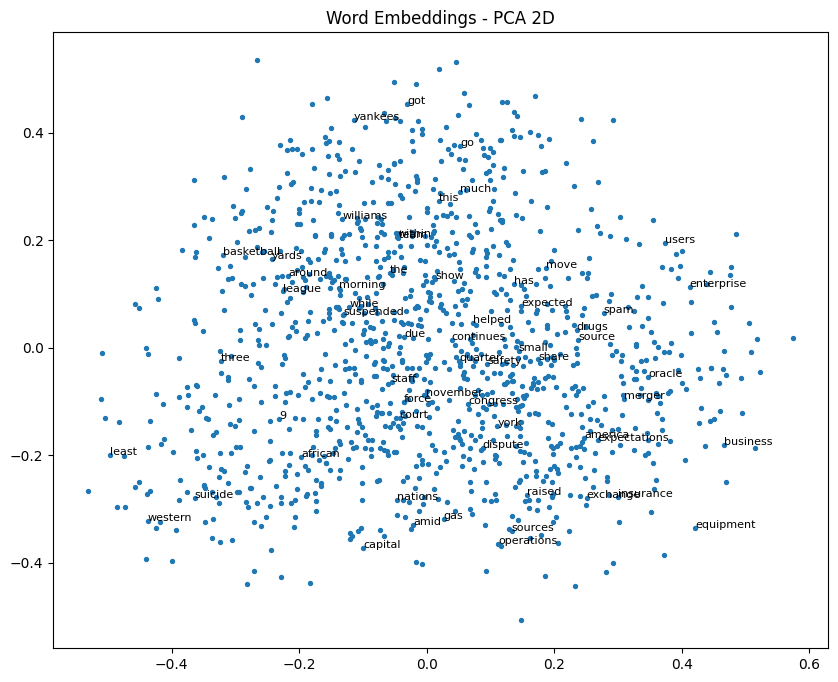

In [61]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=8)
plt.title("Word Embeddings - PCA 2D")

for i in range(0, len(words), max(1, len(words)//60)):
    plt.text(X_pca[i, 0], X_pca[i, 1], words[i], fontsize=8)

plt.show()

Text(0.5, 1.0, 'Word Embeddings - t-SNE 2D')

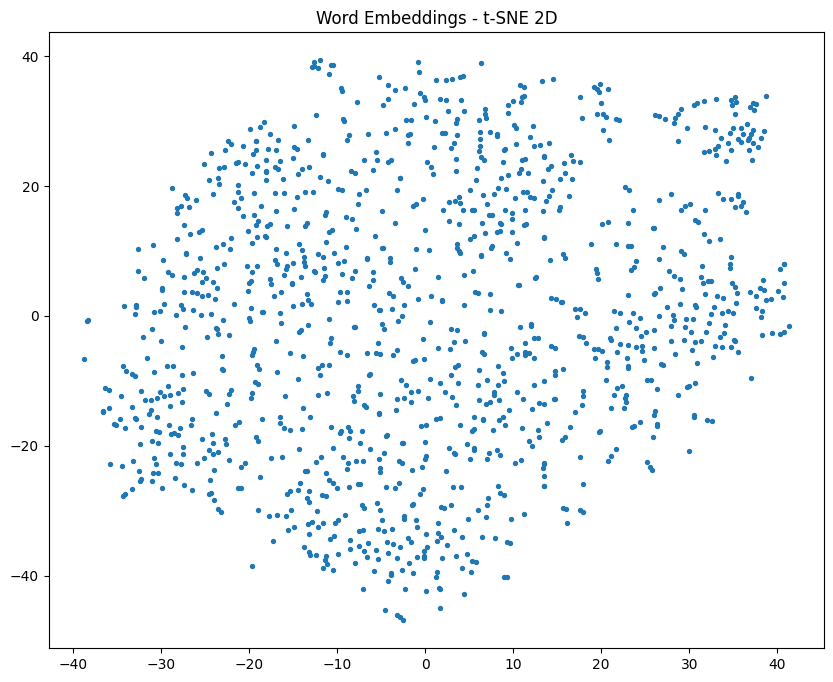

In [60]:
pca_50 = PCA(n_components=min(50, X.shape[1]), random_state=42)
X_50 = pca_50.fit_transform(X)

tsne = TSNE(
    n_components=2,
    perplexity=30,        # try 10–50 depending on n
    learning_rate="auto",
    init="pca",
    random_state=42,
)
X_tsne = tsne.fit_transform(X_50)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=8)
plt.title("Word Embeddings - t-SNE 2D")


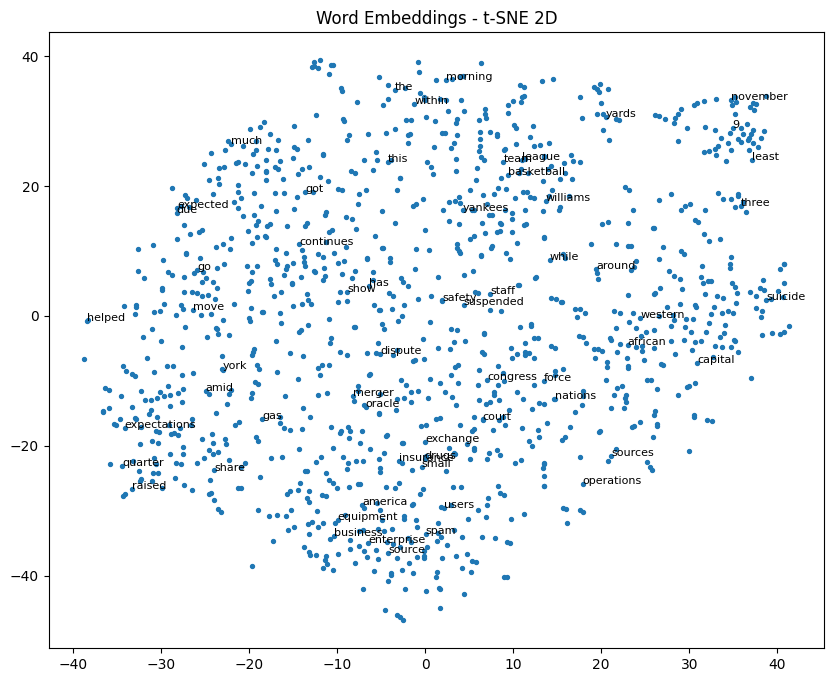

In [62]:
tsne = TSNE(
    n_components=2,
    perplexity=30,        # try 10–50 depending on n
    learning_rate="auto",
    init="pca",
    random_state=42,
)
X_tsne = tsne.fit_transform(X_50)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=8)
plt.title("Word Embeddings - t-SNE 2D")

for i in range(0, len(words), max(1, len(words)//60)):
    plt.text(X_tsne[i, 0], X_tsne[i, 1], words[i], fontsize=8)

plt.show()

In [63]:
def plot_neighborhood(center_word, topk=40, method="pca"):
    center_id = word_to_wid(center_word)
    nbrs = nearest_neighbors(center_word, topk=topk)
    ids = [center_id] + [word_to_wid(tok) for tok, _ in nbrs]
    toks = [center_word] + [tok for tok, _ in nbrs]

    Y = emb_norm[np.array(ids)]
    if method == "tsne":
        Yp = PCA(n_components=min(30, Y.shape[1]), random_state=42).fit_transform(Y)
        coords = TSNE(n_components=2, perplexity=10, init="pca", learning_rate="auto", random_state=42).fit_transform(Yp)
    else:
        coords = PCA(n_components=2, random_state=42).fit_transform(Y)

    plt.figure(figsize=(9, 7))
    plt.scatter(coords[:, 0], coords[:, 1], s=20)
    plt.title(f"Neighborhood of '{center_word}' ({method.upper()})")
    for i, t in enumerate(toks):
        plt.text(coords[i, 0], coords[i, 1], t, fontsize=10)
    plt.show()


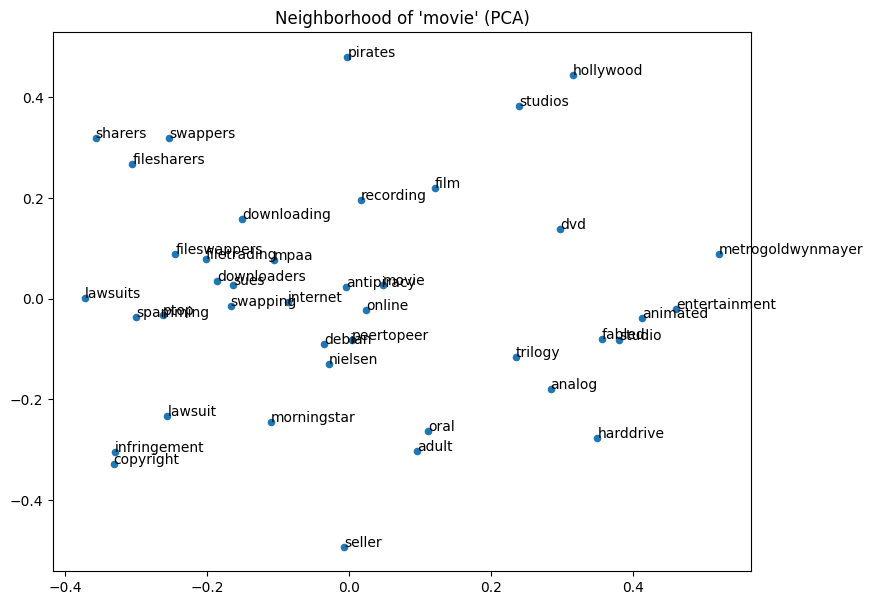

In [64]:
plot_neighborhood("movie", topk=40, method="pca")